In [1]:
# Import the libraries required
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import os
import sys
from azureml.core import Experiment, RunConfiguration, ScriptRunConfig
from azureml.widgets import RunDetails
from azureml.core import Workspace
from azureml.core.environment import CondaDependencies
from azureml.core import Experiment, Run

D:\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
    color: black !important;
    text-align: left;
}
</style>

In [3]:
ccp=pd.read_excel(r'D:\CCPP\CCPP\Folds5x2_pp.xlsx',sheet_name=None)

In [4]:
df=pd.DataFrame()
for i in ccp.values():
    temp=pd.DataFrame(i)
    df=pd.concat([df,temp])

In [5]:
df=pd.DataFrame(ccp['Sheet1'])

In [6]:
df.shape

(9568, 5)

In [7]:
df.corr()

,AT,V,AP,RH,PE
AT,1.000000,0.844107,-0.507549,-0.542535,-0.948128
V,0.844107,1.000000,-0.413502,-0.312187,-0.869780
AP,-0.507549,-0.413502,1.000000,0.099574,0.518429
RH,-0.542535,-0.312187,0.099574,1.000000,0.389794
PE,-0.948128,-0.869780,0.518429,0.389794,1.000000


In [8]:
df.dtypes

AT    float64
V     float64
AP    float64
RH    float64
PE    float64
dtype: object

In [9]:
df.columns

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')

In [10]:
df.dtypes

AT    float64
V     float64
AP    float64
RH    float64
PE    float64
dtype: object

In [11]:
#Abishek
'''To plot the time series,box plot and desnity plots'''

def plots_2(dataframe,col):
    plot8 = plt.figure(figsize=(35,30))
    ax1=plt.subplot(1,2,1)
    bdict=ax1.boxplot(dataframe[col].dropna(),showmeans=True,showfliers=True,meanline=True,meanprops={'linewidth':3,'linestyle':'-','label':'mean'}
                 ,medianprops={'linewidth':3,'label':'median'})
    for line in bdict['boxes']:
        x, y = line.get_xydata()[0] # bottom of left line
        plt.text(x-0.030,y+0.36,'%.1f' % y,
             horizontalalignment='center', # centered
             verticalalignment='top',fontsize=28) # below
        x, y = line.get_xydata()[3] # bottom of right line
        plt.text(x-0.055,y+2.3, '%.1f' % y,
        horizontalalignment='center', # centered
        verticalalignment='top',fontsize=28) # below
    ax1.tick_params(labelsize=28)
    ax1.grid(True,linewidth=2)
    ax1.set_title('Box plot of '+col,size=36)
    _=ax1.legend(prop={'size':30})
    # Density plot
    ax2=plt.subplot(1,2,2)
    _ = sns.distplot(dataframe[col].dropna(),ax=ax2)
    ax2.tick_params(labelsize=26)
    ax2.grid(True,linewidth=2)
    mean=dataframe[col].mean()
    median=dataframe[col].median()
    _=plt.axvline(mean,color='green',linewidth=6,label='mean')
    _=plt.axvline(median,color='red',linewidth=6,label='median')
    ax2.set_xlabel(col,size=26)
    ax2.set_title('Density plot of '+col,size=36)
    ax2.legend(prop={'size':30})
    plot8.savefig('D:/CCPP/'+'Univariate_'+col+'.png',dpi=plot8.dpi)
    plt.close()
    return plot8

In [12]:
def correlation_heatmap(df):
    plot7=plt.figure(figsize=(12,12))
    #plt.title('Correlation heatmap',fontsize=21) 
    p = sns.heatmap(df.T, cmap='GnBu_r',vmin=0, vmax=1,linecolor='black', linewidths=0.1,
                    square=True, annot=True,cbar=False ,annot_kws={'size':19},fmt='.2f')
    #p.set_ylabel('Controller',fontsize=32)
    #p.set_xlabel('Mode',fontsize=32)
    p.axes.spines['top'].set_visible(True)
    p.axes.spines['left'].set_visible(True)
    p.axes.spines['right'].set_visible(True)
    p.axes.spines['bottom'].set_visible(True)
    plt.yticks(rotation=0,size=25)
    plt.xticks(rotation=0,size=25)
    p.figure.savefig('D:/CCPP/'+'Correlation_Heatmap'+'.png', dpi=500, bbox_inches='tight')
    plt.show()
    plt.close()
    return plot7

In [13]:
def scatter(dataframe,col1,col2):
    #mode1 color implies it is the lesser dominant mode
    plot6 = plt.figure(figsize=(17,12))
    ax=plt.subplot(111)
    _=sns.scatterplot(df[col1],df[col2],color='green')
    ax.set_xlabel(col1,size=28)
    ax.set_ylabel(col2,size=18)
    ax.set_title('Variation of '+col1+' with '+col2,size=23)
    plt.yticks(rotation=0,size=24)
    plt.xticks(rotation=0,size=24)
    plot6.savefig('D:/CCPP/'+col1+'_'+col2+'.png', dpi=500, bbox_inches='tight')
    plt.close()
    return plot6

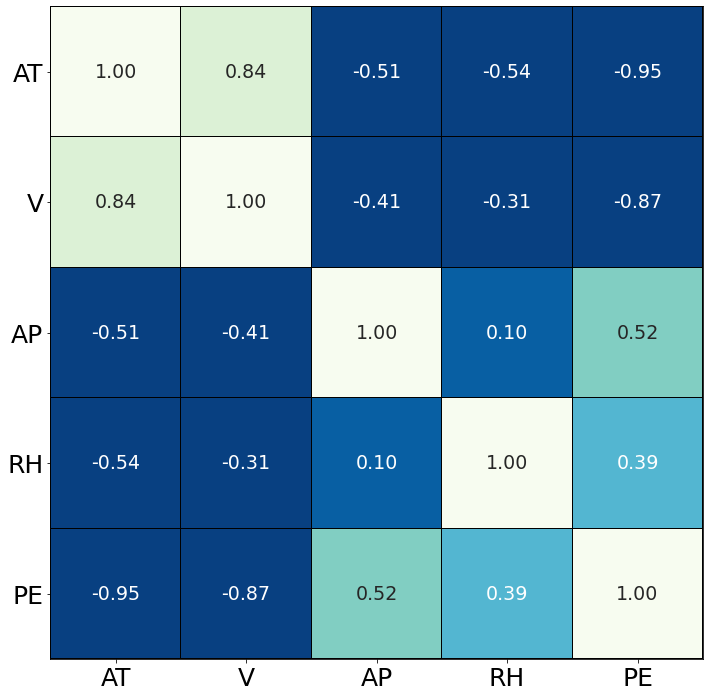

In [14]:
Y = 'PE'
X=['AT','AP','RH','V']
for col in X:
    _=plots_2(df,col)
    _=scatter(df,col,Y)
cmap=correlation_heatmap(df.corr())

## We then move onto generating the scatter plots between the various variables in order to check for multicollinearity

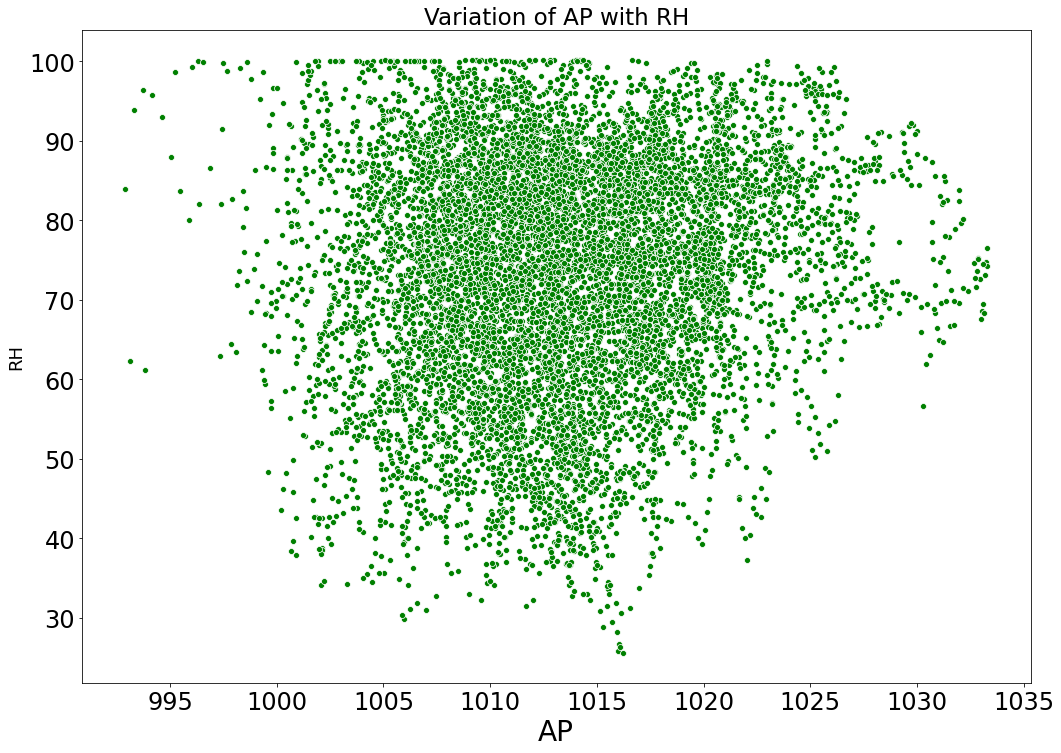

In [15]:
scatter(df,'AT','V')
scatter(df,'AT','AP')
scatter(df,'AT','RH')
scatter(df,'V','AP')
scatter(df,'V','RH')
scatter(df,'AP','RH')

# Perform the above K-Fold Experiment in AzureML

In [16]:
%%writefile CCPP_Linear_reg.py
from azureml.core import Run
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib
import matplotlib.pyplot as plt

ccp=pd.read_excel(r'D:\CCPP\CCPP\Folds5x2_pp.xlsx',sheet_name=None)
# Get the experiment run context
run = Run.get_context()

kfold = KFold(2, False)
rmsescores=[]
r2scores=[]
i=0
for shuffle in ccp.values():
    temp=pd.DataFrame(shuffle)
    X=temp['AT']
    Y=temp['PE']
    # enumerate splits
    for train, test in kfold.split(X):
        i=i+1
        run.log_row('Split sizes', train_set_size=len(train),test_set_size=len(test))
        reg = LinearRegression(normalize=True).fit(np.array(X[train]).reshape(-1, 1), np.array(Y[train]).reshape(-1, 1))
        predictions=reg.predict(np.array(X[test]).reshape(-1, 1))
        #run.log_list('Predictions',list(predictions))
        # Plot outputs
        plot6 = plt.figure(figsize=(17,12))
        ax=plt.subplot(111)
        plt.scatter(X[test], Y[test],color='blue')
        plt.plot(X[test], predictions,c='black', linewidth=3)
        run.log_image('Iteration'+str(i),None,plot6)
        rmse=round(mean_squared_error(Y[test], predictions, squared=False),2)
        r2score=round(r2_score(np.array(Y[test]).reshape(-1, 1), np.array(predictions).reshape(-1, 1)),2)
        rmsescores.append(rmse)
        r2scores.append(r2score)
        print(reg.intercept_[0]," + X*",reg.coef_[0][0])
run.log_table('Model_Ability',{'RMSE scores':rmsescores,'R2 scores':r2scores})        
# Complete the run
run.complete()

Overwriting CCPP_Linear_reg.py


In [17]:
# Load the workspace required
ws = Workspace.get("ExperimentalWork")
print(ws.name, "loaded")

ExperimentalWork loaded


In [18]:
# Create the extra dependencies to be added to the Run Config
conda_dep = CondaDependencies()
conda_dep.add_conda_package("scikit-learn")
conda_dep.add_conda_package("xlrd")
conda_dep.add_conda_package("matplotlib")
conda_dep.add_conda_package("ipykernel")

# create a new RunConfig object
experiment_run_config = RunConfiguration(conda_dependencies=conda_dep)

# Create a script config
src = ScriptRunConfig(source_directory='D:\CCPP', 
                      script='CCPP_Linear_reg.py',
                      run_config=experiment_run_config) 

# submit the experiment
experiment = Experiment(workspace = ws, name = 'CCPP-With_LinearReg')
run = experiment.submit(config=src)
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'CCPP-With_LinearReg_1596910986_edb550a4',
 'target': 'local',
 'status': 'Finalizing',
 'startTimeUtc': '2020-08-08T18:23:17.461596Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': 'af473331-86d9-417f-94b7-c81d458a481e'},
 'inputDatasets': [],
 'runDefinition': {'script': 'CCPP_Linear_reg.py',
  'scriptType': None,
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  'jobName': None,
  'maxRunDurationSeconds': None,
  'nodeCount': 1,
  'environment': {'name': 'Experiment CCPP-With_LinearReg Environment',
   'version': 'Autosave_2020-08-05T18:38:14Z_0d279fc0',
   'python': {'interpreterPath': 'python',
    'userManagedDependencies': False,
    'condaDependencies': {'channels': ['anaconda', 'conda-forge'],
     'dependencies': ['python=3.6.2',
      {'pip': ['azureml-defaults']},
      

In [19]:
# Get logged metrics
metrics = run.get_metrics()
for key in metrics.keys():
        print(key, metrics.get(key))
print('\n')

Split sizes {'train_set_size': [4784, 4784, 4784, 4784, 4784, 4784, 4784, 4784, 4784, 4784], 'test_set_size': [4784, 4784, 4784, 4784, 4784, 4784, 4784, 4784, 4784, 4784]}
Iteration1 aml://artifactId/ExperimentRun/dcid.CCPP-With_LinearReg_1596910986_edb550a4/Iteration1_1596911040.png
Iteration2 aml://artifactId/ExperimentRun/dcid.CCPP-With_LinearReg_1596910986_edb550a4/Iteration2_1596911044.png
Iteration3 aml://artifactId/ExperimentRun/dcid.CCPP-With_LinearReg_1596910986_edb550a4/Iteration3_1596911046.png
Iteration4 aml://artifactId/ExperimentRun/dcid.CCPP-With_LinearReg_1596910986_edb550a4/Iteration4_1596911048.png
Iteration5 aml://artifactId/ExperimentRun/dcid.CCPP-With_LinearReg_1596910986_edb550a4/Iteration5_1596911051.png
Iteration6 aml://artifactId/ExperimentRun/dcid.CCPP-With_LinearReg_1596910986_edb550a4/Iteration6_1596911053.png
Iteration7 aml://artifactId/ExperimentRun/dcid.CCPP-With_LinearReg_1596910986_edb550a4/Iteration7_1596911055.png
Iteration8 aml://artifactId/Experimen

In [20]:
#Checking if the required plots are stored as expected
for file in run.get_file_names():
    print(file)

Iteration10_1596911062.png
Iteration1_1596911040.png
Iteration2_1596911044.png
Iteration3_1596911046.png
Iteration4_1596911048.png
Iteration5_1596911051.png
Iteration6_1596911053.png
Iteration7_1596911055.png
Iteration8_1596911058.png
Iteration9_1596911060.png
azureml-logs/60_control_log.txt
azureml-logs/70_driver_log.txt
logs/azureml/4488_azureml.log


In [21]:


diabetes_experiment = ws.experiments['CCPP-With_LinearReg']
for logged_run in diabetes_experiment.get_runs():
    print('Run ID:', logged_run.id)
    metrics = logged_run.get_metrics()
    for key in metrics.keys():
        print('-', key, metrics.get(key))

Run ID: CCPP-With_LinearReg_1596910986_edb550a4
- Split sizes {'train_set_size': [4784, 4784, 4784, 4784, 4784, 4784, 4784, 4784, 4784, 4784], 'test_set_size': [4784, 4784, 4784, 4784, 4784, 4784, 4784, 4784, 4784, 4784]}
- Iteration1 aml://artifactId/ExperimentRun/dcid.CCPP-With_LinearReg_1596910986_edb550a4/Iteration1_1596911040.png
- Iteration2 aml://artifactId/ExperimentRun/dcid.CCPP-With_LinearReg_1596910986_edb550a4/Iteration2_1596911044.png
- Iteration3 aml://artifactId/ExperimentRun/dcid.CCPP-With_LinearReg_1596910986_edb550a4/Iteration3_1596911046.png
- Iteration4 aml://artifactId/ExperimentRun/dcid.CCPP-With_LinearReg_1596910986_edb550a4/Iteration4_1596911048.png
- Iteration5 aml://artifactId/ExperimentRun/dcid.CCPP-With_LinearReg_1596910986_edb550a4/Iteration5_1596911051.png
- Iteration6 aml://artifactId/ExperimentRun/dcid.CCPP-With_LinearReg_1596910986_edb550a4/Iteration6_1596911053.png
- Iteration7 aml://artifactId/ExperimentRun/dcid.CCPP-With_LinearReg_1596910986_edb550a4